In [1]:
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

## Preprocess on Dataset

In [2]:
BATCH_SIZE = 32

def read_image_and_annotation(image, annotation):

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation

def get_training_dataset(images, annos):
  
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)
  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset

def get_validation_dataset(images, annos):

  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):

  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset

In [4]:
images = np.load('/tmp/training/combined.npy')
segments = np.load('/tmp/training/segmented.npy')
train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)
train_slices, val_slices, test_slices = (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

## Visualization of dataset

In [5]:
n_classes = 11

colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im

def give_color_to_annotation(annotation):
 
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):

  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


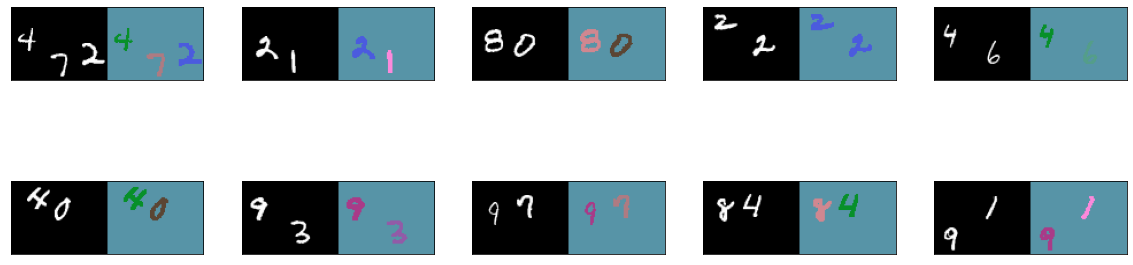

In [6]:
# get 10 images from the training set
list_show_annotation(training_dataset, 10)

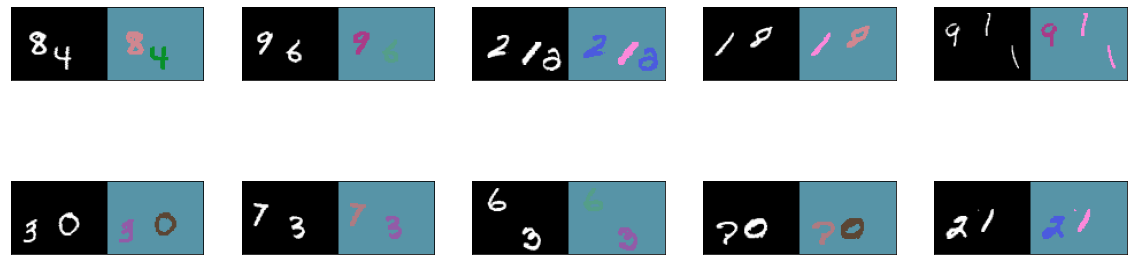

In [7]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

# Model Architecture

In [8]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides):

  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, pool_strides, padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size= pooling_size, strides= pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [9]:
def FCN8(input_height=64, input_width=84):

    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 1))
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96-input_width)))(img_input)
    x = conv_block(x, 32, 2, 2, 2)
    x = conv_block(x, 64, 2, 2, 2)
    x = conv_block(x, 128, 2, 2, 2)
    f3 = x
    x = conv_block(x, 256, 2, 2, 2)
    f4 = x
    x = conv_block(x, 256, 2, 2, 2)
    f5 = x

    return (f3, f4, f5), img_input

In [10]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs
  n = 512
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)
  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)
  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)

  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  o2 = f4
  o2 = (tf.keras.layers.Conv2D(n_classes , (1,1) , activation='relu' , padding='same'))(o2)
  o = tf.keras.layers.Add()([o, o2])

  o =  (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2)))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  o2 =  f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  o = tf.keras.layers.Add()([o, o2])

  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8))(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [11]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   160         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [13]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True), 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Model Training

In [ ]:
EPOCHS = 300

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

In [15]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

(192, 64, 84, 11)


In [16]:
print(results[0,0,0,0])
print(results[0,0,0,10])

6.782292e-05
0.99942744


In [17]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


In [18]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


We will use this `results` array when we evaluate our predictions.

In [19]:
def class_wise_metrics(y_true, y_pred):

  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

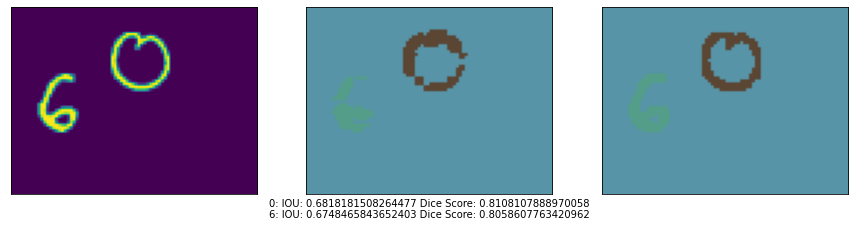

In [22]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 105

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
  
iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])  
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


In [21]:
model.save("model.h5")